# Zoneplate
A [zoneplate](https://en.wikipedia.org/wiki/Zone_plate) is a lens based on diffraction of light. We will use PyPropagate to calculate the stationary field in a binary zoneplate and its focal point in paraxial approximation.

In [109]:
from pypropagate import *
%matplotlib inline

## Zoneplate propagation
### Configuring the propagator
We define the settings for propagation inside the zoneplate. The zoneplate parameters are stored in a own category.

In [110]:
zoneplate_settings = presets.settings.create_paraxial_wave_equation_settings()
s = zoneplate_settings.symbols

In [111]:
zp = zoneplate_settings.create_category("zoneplate",info="Zoneplate parameters")
zp.create_symbol("F",info="Focal length")
zp.create_symbol("z_F",zp.F+s.sz/2,info="Focal spot")
zp.create_symbol("n1",info="Index of refraction of the zoneplate")
zp.create_symbol("n2",info="Index of refraction")
zp.create_symbol("N",info="Number of zones",type=pc.Types.Integer)
zp.create_symbol("i",info="Zone index",type=pc.Types.Integer)
zp.create_function("r",(zp.i,),info="radius of zone i")
zp.create_symbol("R",zp.r.function(2*zp.N+1),info="radius of the zoneplate");

We define a formula for the zone radii.

In [112]:
zp.r = pc.sqrt(zp.i*s.wavelength*zp.F + zp.i**2*s.wavelength**2 / 4)
zoneplate_settings.get_definition(zp.r)

sqrt((lambda(omega)*i_zoneplate)**2/4+lambda(omega)*F_zoneplate*i_zoneplate)

We set the refractive indices of the zones to Tantalum and Vacuum. There will be $50$ Zones with a focal point at $1\text{mm}$.

In [113]:
zp.F = 1*units.mm
zp.n1 = presets.medium.create_material('Ta',zoneplate_settings)
zp.n2 = 1
zp.N = 50

The simulation box is defined large enough to contain all zones with some extra space we call padding. The simulation box size in $z$ direction corresponds to the thickness of the zoneplate.

In [127]:
padding = 0.2
s.zmin = 0
s.zmax = 100*units.um
s.Nz = 10000
s.xmax = (1+padding)*zp.R
s.xmin = -s.xmax
s.Nx = 15000
zoneplate_settings.wave_equation.set_energy(12*units.keV)
presets.boundaries.set_plane_wave_initial_conditions(zoneplate_settings)

We save the zones information in a one-dimensional binary array where the index corresponds to the distance from the center. Since we want to be able to change zoneplate parameters at  any time the zoneplate array should be created as a last step before the simulation. Therefore we define the function that creates the zoneplate array as an initializer function.

In [128]:
def create_zoneplate_array(settings):
    s = settings.symbols            
    key = settings.get_unitless(tuple(zp.keys()+[s.dx]))
    
    # Avoid unnecessary re-calculation of the zones
    cached = settings.get_cache().get('zoneplate_array')
    if cached is None or cached != key:        
        size = settings.get_as(zp.R/s.dx+0.5,int)
        ro = 0
        zf = pc.numpyfy(settings.get_unitless(pc.floor(zp.r/s.dx)))
        zones = zf(i_zoneplate = range(settings.get_as(2*(zp.N+1),int)))
        zoneplate_array = np.ones(size,dtype=np.bool)
        for ri,ro in zip(zones[::2],zones[1::2]):
            zoneplate_array[ri:ro] = np.zeros(ro-ri,dtype=np.bool)
        zoneplate_function = pc.array("zones",zoneplate_array)
        inside_zoneplate_r = pc.equal(zoneplate_function(pc.floor(pc.sqrt(s.x**2+s.y**2)/s.dx + 0.5)),0)
        s.n = pc.piecewise((zp.n1,inside_zoneplate_r),(zp.n2,True))
        settings.get_cache()['zoneplate_array'] = key
                
zoneplate_settings.initializers['create_zoneplate_array'] = create_zoneplate_array

To verify the settings we plot the refraction index at $y=0$.

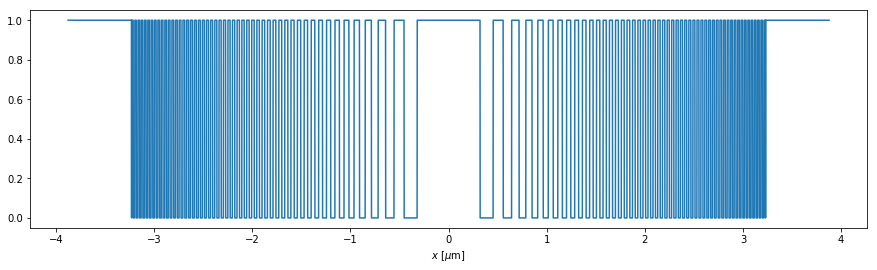

In [187]:
n = s.n.function
plot(expression_to_array(pc.unequal(n(s.x,0,s.zmin),1),zoneplate_settings),figsize=(15,4));

### Calculating the field in the zoneplate
In this example we determine the 2 dimensional stationary solution of the zoneplate. Since we are propataging in material, we use the finite difference propagator.

In [130]:
zppropagator = propagators.FiniteDifferencesCS(zoneplate_settings)
zpfield = zppropagator.run_slice()[0::,::10*s.dz]

propagating:|██████████████████████| 999/999 [18.7s < 0(0)s]]


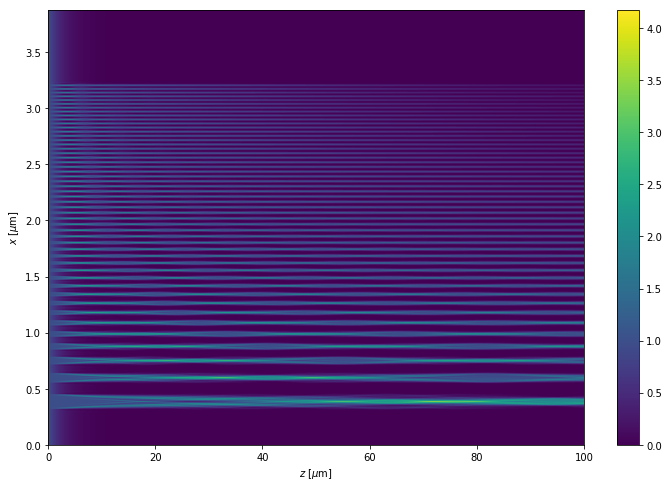

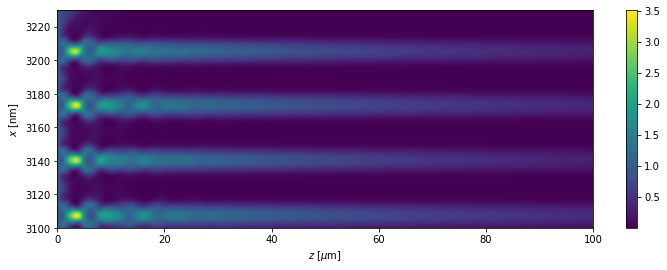

In [133]:
plot(zpfield,figsize=(12,8));
plot(zpfield[3.1*units.um:zp.R],figsize=(12,4))

## Vacuum propagation
We will use the exit field of the finite difference propagator as the initial field for propagation in vacuum. Since we are not interested in the pre-focal field we will do a single step up to 80% of the focal length. To avoid reflections from the boundary we will add further padding to the simulation box. 

In [176]:
def add_absorbing_padding_x(settings,size,n = None):
    from pypropagate import pc,presets
    if n is None:
        n = presets.medium.create_material('Pb',settings)
    s = settings.symbols
    r = pc.Max(pc.Max(0,(s.x - s.xmax + size)/size),(-s.x + s.xmin + size)/size)
    s.n = settings.get_numeric(s.n) * (1-r) + r * n

In [179]:
vacuum_settings = presets.settings.create_next_settings(zoneplate_settings)
vacuum_settings.wave_equation.n = 1
add_absorbing_padding_x(vacuum_settings,s.sx/2 - zp.R)
vacuum_settings.simulation_box.sz = 0.8 * zoneplate_settings.get_numeric(zp.z_F - s.sz/2)
vacuum_settings.simulation_box.Nz = 10000
initial = presets.boundaries.add_padding(zppropagator.get_field(),0.25)
presets.boundaries.set_initial(vacuum_settings,initial)

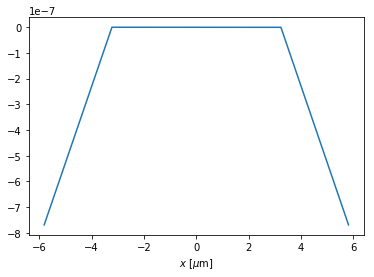

In [180]:
plot(pc.imag(s.n),vacuum_settings)

Since we will propagate in vacuum over a large distance we choose the fresnel propagator.

In [191]:
vapropagator = propagators.FiniteDifferencesCS(vacuum_settings)
field = vapropagator.run_slice()[::s.sx/2000,::s.sz/1000]

propagating:|██████████████████████| 999/999 [32.6s < 0(0)s]]


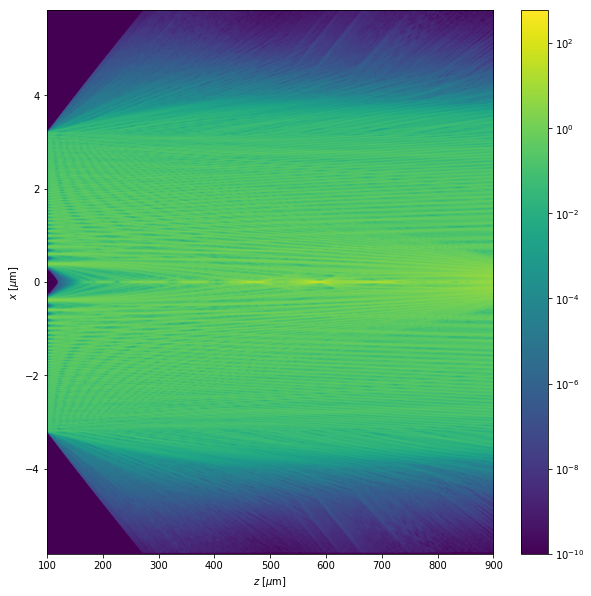

In [192]:
from matplotlib.colors import LogNorm
plot(field[:],figsize=(10,10),norm=LogNorm(10**-10))

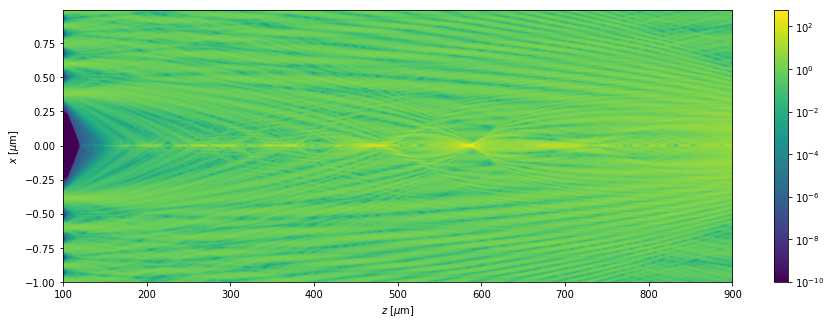

In [193]:
plot(field[-1*units.um:1*units.um],figsize=(15,5),norm=LogNorm(10**-10))

## Focal point propagation
Using the exit field from the last propagator we can now propagate through the focal point.

In [183]:
focus_settings = presets.settings.create_next_settings(vacuum_settings)
focus_settings.wave_equation.n = 1
focus_settings.simulation_box.sz = 300 * units.um
focus_settings.simulation_box.Nz = 10000
presets.boundaries.set_initial(focus_settings,vapropagator.get_field())

Since we are in vacuum we again use the fresnel propagator to calculate the field. We plot the field intesity as well as the intensity of a slice at $x = 0$.

In [184]:
focuspropagator = propagators.FiniteDifferencesCS(focus_settings)
focus_field = focuspropagator.run_slice()[-units.um:units.um:2*units.um/1000,::s.sz/1000]

propagating:|██████████████████████| 999/999 [26.1s < 0(0)s]]


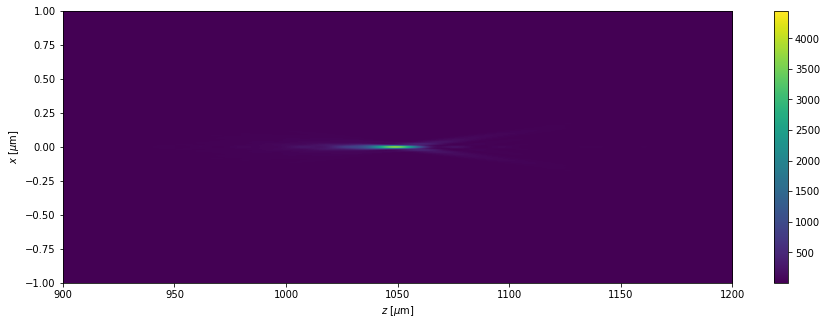

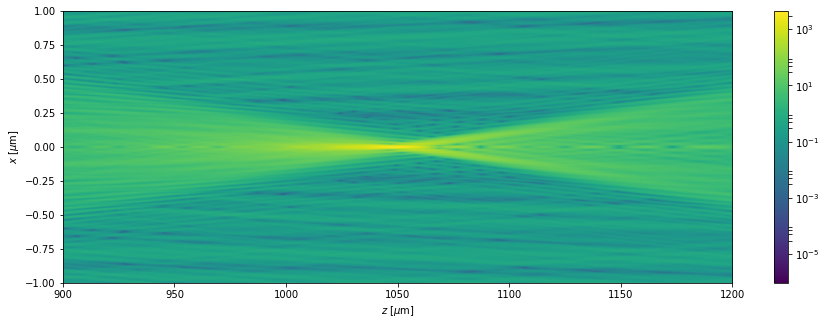

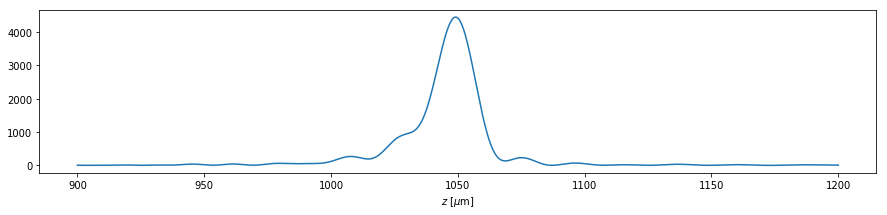

In [185]:
plot(focus_field,figsize=(15,5))
plot(focus_field,figsize=(15,5),norm=LogNorm())
plot(focus_field[0],figsize=(15,3));